Notebook to compile phenotype information from zfin with the aim of identifying interesting potential KO targets. I use zfin's anatomy graph to identify genes that impact important developmental processes and structure. 

In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import plotly.express as px
import os

### Load zfin data

In [2]:
# set path to raw data
raw_data_root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/zfin/raw_data/"
access_date = "20240326"
anatomy_nodes_df = pd.read_csv(os.path.join(raw_data_root, access_date, "anatomy_item.txt"), sep='\t', header=1)
anatomy_edges_df = pd.read_csv(os.path.join(raw_data_root, access_date, "anatomy_relationship.txt"), sep='\t', header=1)
anatomy_synonyms_df = pd.read_csv(os.path.join(raw_data_root, access_date, "anatomy_synonyms.txt"), sep='\t', header=1)
zfin_pheno_df_raw = pd.read_csv(os.path.join(raw_data_root, access_date, "phenoGeneCleanData_fish.txt"), sep='\t', header=1)
stage_df = pd.read_csv(os.path.join(raw_data_root, access_date, "stage_ontology.txt"), sep='\t', header=1)

# make output directory
built_data_dir = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/zfin/built_data/20240326/"
if not os.path.isdir(built_data_dir):
    os.makedirs(built_data_dir)
    
fig_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/zfin/figures/"
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)

In [32]:
# load gene info dataset
gene_info_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/zfin/built_data/20240326/gene_set_mf.csv"
gene_info_df = pd.read_csv(gene_info_path)

# load zfin gene descriptions
zfin_gene_desc_df = pd.read_csv(os.path.join(raw_data_root, access_date, 
                        "GENE-DESCRIPTION-TSV_ZFIN.tsv"), sep='\t', header=13,
                               names=["gene_ID", "gene", "gene_desc"])
zfin_gene_desc_df.head()

gene_ID   gene  \
0   ZFIN:ZDB-GENE-141212-335  tnxbb   
1  ZFIN:ZDB-GENE-030131-6657  banf1   
2     ZFIN:ZDB-GENE-190705-2    mxp   
3     ZFIN:ZDB-GENE-190705-4    dun   
4   ZFIN:ZDB-GENE-070117-101    rub   

                                           gene_desc  
0                           No description available  
1  Predicted to enable DNA binding activity. Pred...  
2                           No description available  
3                           No description available  
4                           No description available

## Build cleaned zfin dataset

In [4]:
# string searching to flag results that are based on morpholinos. This likely misses quite a bit, but is a good start
disp_vec = zfin_pheno_df_raw["Fish Display Name"].tolist()
MO_flags = [1 if "MO" in disp else 0 for disp in disp_vec]
zfin_pheno_df_raw["morpholino_flag"] = MO_flags

# clean up column names
zfin_pheno_df = zfin_pheno_df_raw.rename(columns={
            "Affected Structure or Process 1 superterm ID": "structure_ID",
            "Affected Structure or Process 1 superterm Name": "structure",
            "Gene Symbol" : "gene",
            "Gene ID": "gene_ID",
            "Phenotype Keyword ID": "pheno_ID",
            "Phenotype Keyword Name": "phen_type",
            "Phenotype Tag": "phen_tag"
}).loc[:, ["gene", "gene_ID", "structure", "structure_ID", 'phen_tag', 'phen_type',
           "morpholino_flag", "pheno_ID",
           "Start Stage ID", "End Stage ID"]]

# add staging info
zfin_pheno_df = zfin_pheno_df.merge(stage_df.loc[:, ["Stage ID", "Begin Hours"]], how="left", 
                                    left_on="Start Stage ID", right_on="Stage ID").drop(columns="Stage ID")

zfin_pheno_df = zfin_pheno_df.rename(columns={"Begin Hours":"start_hpf"})

zfin_pheno_df = zfin_pheno_df.merge(stage_df.loc[:, ["Stage ID", "End Hours"]], how="left", 
                                    left_on="End Stage ID", right_on="Stage ID").drop(columns="Stage ID")

zfin_pheno_df = zfin_pheno_df.rename(columns={"End Hours":"end_hpf"}).drop(columns=["Start Stage ID", "End Stage ID"])

zfin_pheno_df.head(5)

gene            gene_ID         structure structure_ID  phen_tag  \
0    3m76  ZDB-GENE-210324-7              axis  ZFA:0000092  abnormal   
1    3m76  ZDB-GENE-210324-7  vertebral column  ZFA:0001559  abnormal   
2    4m99  ZDB-GENE-210324-8              axis  ZFA:0000092  abnormal   
3    4m99  ZDB-GENE-210324-8  vertebral column  ZFA:0001559  abnormal   
4  aanat2  ZDB-GENE-991019-6             sleep   GO:0030431  abnormal   

             phen_type  morpholino_flag      pheno_ID  start_hpf  end_hpf  
0  increased curvature                0  PATO:0001592      720.0   1080.0  
1  increased curvature                0  PATO:0001592      720.0   1080.0  
2  increased curvature                0  PATO:0001592      720.0   1080.0  
3  increased curvature                0  PATO:0001592      720.0   1080.0  
4   decreased duration                0  PATO:0000499      120.0    168.0

Count number of non-morpholino reports corresponding to each gene-phenotype combo. Keep only those with at least one

In [5]:
# remove morpholino observations
print(zfin_pheno_df.shape)
zfin_pheno_clean = zfin_pheno_df.loc[zfin_pheno_df["morpholino_flag"]==0, :].copy()

# filter for only abnormal phneotypes (I think this has no effect)
print(zfin_pheno_clean.shape)
zfin_pheno_clean = zfin_pheno_clean.loc[zfin_pheno_clean["phen_tag"]=='abnormal', :].drop_duplicates()

# keep only effects that begin no later than 72hpf
print(zfin_pheno_clean.shape)
zfin_pheno_clean = zfin_pheno_clean.loc[zfin_pheno_clean["start_hpf"]<=72, :]

# remove any remaing phenotypes that do not have a "ZFA" code (anatomical effects)
print(zfin_pheno_clean.shape)
id_vec = zfin_pheno_clean.loc[:, "structure_ID"].tolist()
keep_flags = np.asarray(["ZFA" in i for i in id_vec])
zfin_pheno_clean = zfin_pheno_clean.loc[keep_flags]

# Keep only structures that are in the anatomy graph (ideally they should all be in there)
print(zfin_pheno_clean.shape)
zfin_pheno_clean = zfin_pheno_clean.merge(anatomy_nodes_df.loc[:, ["Anatomy ID"]].drop_duplicates(), how="inner",
                                    left_on="structure_ID", right_on="Anatomy ID")
zfin_pheno_clean = zfin_pheno_clean.drop(labels=["Anatomy ID"], axis=1)
print(zfin_pheno_clean.shape)

# remove 'whole organism' and 'unspecified' instances
zfin_pheno_clean = zfin_pheno_clean.loc[zfin_pheno_clean["structure_ID"]!="ZFA:0001094"]
zfin_pheno_clean = zfin_pheno_clean.loc[zfin_pheno_clean["structure_ID"]!="ZFA:0001093"]
print(zfin_pheno_clean.shape)

# Save
zfin_pheno_clean = zfin_pheno_clean.loc[:, ["gene", "gene_ID", "structure", "structure_ID", "phen_type", "start_hpf", "end_hpf"]]
zfin_pheno_clean.to_csv(os.path.join(built_data_dir, "cleaned_gene_phenotypes.csv"),index=False)

(152927, 10)
(89965, 10)
(59240, 10)
(33389, 10)
(27691, 10)
(27691, 10)
(24774, 10)


In [7]:
# De-dupe phenotypes 
zfin_pheno_agg1 = zfin_pheno_clean.copy()
print(zfin_pheno_agg1.shape)
zfin_pheno_agg1["report_counts"] = 1
zfin_pheno_agg1 = zfin_pheno_agg1.groupby(
                        ["gene", "gene_ID", "structure", "structure_ID"]).agg({
                    "phen_type": lambda x: ', '.join(x), "start_hpf": "min", "end_hpf": "max", 
                    "report_counts": "count"}).reset_index(drop=False)
print(zfin_pheno_agg1.shape)
zfin_pheno_agg1.head(4)

(24774, 7)
(14688, 8)


gene              gene_ID                           structure  \
0  abcb11b   ZDB-GENE-050517-14                          hepatocyte   
1    abcc4  ZDB-GENE-030616-511                   Kupffer's vesicle   
2    abcc4  ZDB-GENE-030616-511                               brain   
3    abcc4  ZDB-GENE-030616-511  green sensitive photoreceptor cell   

  structure_ID                                          phen_type  start_hpf  \
0  ZFA:0009111                                       mislocalised      72.00   
1  ZFA:0000001  decreased length, has fewer parts of type, dec...      11.66   
2  ZFA:0000008                           hydrocephalic, edematous      72.00   
3  ZFA:0009223           decreased amount, decreased distribution      72.00   

   end_hpf  report_counts  
0    168.0              1  
1     14.0              3  
2     96.0              2  
3     96.0              2

In [51]:
# join on gene ontology info
gene_info_clean = gene_info_df.loc[:, ["gene_symbol", "gs_name", "gs_description"]].rename(columns={"gene_symbol": "gene"})
tf_flag_vec = [1 if "transcription" in name.lower() else 0 for name in list(gene_info_clean["gs_name"]) ]
gene_info_clean["TF_flag_g"] = tf_flag_vec

# take max of TF flag
gene_info_short = gene_info_clean.loc[:, ["gene", "TF_flag_g"]].groupby(["gene"]).max().reset_index()

# now do the same for zfin descriptions
tf_flags_z = [1 if "transcription" in name.lower() else 0 for name in list(zfin_gene_desc_df["gene_desc"])]
chromatin_flags = [1 if "chromatin" in name.lower() else 0 for name in list(zfin_gene_desc_df["gene_desc"])]
zfin_gene_desc_df["TF_flag_z"] = tf_flags_z
zfin_gene_desc_df["chromatin_flag"] = chromatin_flags
zfin_tf_df = zfin_gene_desc_df.loc[:, ["gene", "TF_flag_z", "chromatin_flag", "gene_desc"]].drop_duplicates()
                            
# merge onto zfin data
# Note, about 15% of genes are not in this reference table and so may be incorrectly labeled as non-TF
gene_pheno_df = zfin_pheno_agg1.loc[:, ["gene", "gene_ID"]].drop_duplicates().merge(
    gene_info_short, how="left", on="gene")
                            
gene_pheno_df = gene_pheno_df.merge(zfin_tf_df, how="left", on="gene")

gene_pheno_df.loc[np.isnan(gene_pheno_df["TF_flag_g"]), "TF_flag_g"] = 0
gene_pheno_df.loc[np.isnan(gene_pheno_df["TF_flag_z"]), "TF_flag_z"] = 0

gene_pheno_df["TF_flag"] = gene_pheno_df[["TF_flag_g", "TF_flag_z"]].max(axis=1)

gene_pheno_df = gene_pheno_df.drop(labels=["TF_flag_g", "TF_flag_z"], axis=1)
gene_pheno_df.head()

gene               gene_ID  chromatin_flag  \
0  abcb11b    ZDB-GENE-050517-14             0.0   
1    abcc4   ZDB-GENE-030616-511             0.0   
2    abcd1    ZDB-GENE-050517-27             0.0   
3    abce1  ZDB-GENE-040426-1995             0.0   
4      abf   ZDB-GENE-070117-775             0.0   

                                           gene_desc  TF_flag  
0  Predicted to enable ABC-type bile acid transpo...      0.0  
1  Enables ABC-type transporter activity; efflux ...      0.0  
2  Predicted to enable several functions, includi...      0.0  
3  Predicted to enable ATP binding activity; iron...      0.0  
4                           No description available      0.0

## Clean up anatomy data and build an ontology graph

In [10]:
# First, construct full graph
edge_vec = anatomy_edges_df["Relationship Type ID"].to_list()
keep_edge_types = ["part of", "is_a"]
keep_flags = np.asarray([e in keep_edge_types for e in edge_vec])

# filter for only desired edge types
edge_df = anatomy_edges_df.loc[keep_flags, ["Parent Item ID", "Child Item ID", "Relationship Type ID"]]
edge_df.reset_index(inplace=True, drop=True)
node_df = anatomy_nodes_df.loc[:, ["Anatomy ID", "Anatomy Name"]].drop_duplicates()
node_df.reset_index(inplace=True, drop=True)
node_df.loc[:, "node_id"] = node_df.index

# get num observations in the zfin database
node_df_temp = node_df.copy().loc[:, ["Anatomy ID", "node_id"]]
node_df_temp = node_df_temp.merge(zfin_pheno_clean.loc[:, "structure_ID"], 
                                  how="left", left_on="Anatomy ID", right_on="structure_ID").loc[:, 
                                                                            ["node_id", "structure_ID"]]
count_df = node_df_temp.groupby("node_id").count()
count_df.reset_index(inplace=True)

node_df = node_df.merge(count_df, how="left", on="node_id")
node_df = node_df.rename(columns={"structure_ID": "zfin_counts"})


# construct node dictionary
anatomy_nodes_id_vec = node_df["Anatomy ID"].to_numpy()
node_container = []
for i, a_term in enumerate(node_df["Anatomy Name"]):
    node_container.append(tuple([i, {"name": a_term, "id": anatomy_nodes_id_vec[i]}]))


# # join node df to edges to get edge IDs
edge_df = edge_df.merge(node_df.loc[:, ["Anatomy ID", "node_id"]], 
                        how="left", left_on="Parent Item ID", right_on="Anatomy ID")
edge_df = edge_df.rename(columns={"node_id":"from_id"})

edge_df = edge_df.merge(node_df.loc[:, ["Anatomy ID", "node_id"]], 
                        how="left", left_on="Child Item ID", right_on="Anatomy ID")
edge_df = edge_df.rename(columns={"node_id":"to_id"})
                         
edge_df = edge_df.loc[:, ["Parent Item ID", "Child Item ID", "Relationship Type ID", "from_id", "to_id"]]
edge_df = edge_df.dropna(subset=["from_id", "to_id"])
edge_df.reset_index(inplace=True, drop=True)
edge_df.head()

Parent Item ID Child Item ID Relationship Type ID  from_id  to_id
0    ZFA:0001129   ZFA:0001130                 is_a   2112.0   2107
1    ZFA:0001129   ZFA:0001131                 is_a   2112.0   2108
2    ZFA:0001129   ZFA:0001132                 is_a   2112.0   2111
3    ZFA:0001129   ZFA:0001133                 is_a   2112.0   2110
4    ZFA:0001129   ZFA:0001134                 is_a   2112.0   2109

In [11]:
import networkx as nx
anatomy_graph = nx.DiGraph()
anatomy_graph.add_nodes_from(node_container)

edge_container = []
for i in range(edge_df.shape[0]):
    edge_container.append(tuple([edge_df.loc[i, "from_id"], edge_df.loc[i, "to_id"]]))
    
anatomy_graph.add_edges_from(edge_container)

Identify nodes with no parent. If a node has no parent and no children, remove it unless it has reported observations in the zfin database.

In [12]:
node_list = anatomy_graph.nodes
root_node_list = []
rm_node_list = []
for node in node_list:
    n_successors = len(list(anatomy_graph.successors(node)))
    n_predecessors = len(list(anatomy_graph.predecessors(node)))
    
    if (n_predecessors==0) and (n_successors > 0):
        root_node_list.append(node)
        
    elif n_predecessors==0:
        if node_df.loc[node_df["node_id"]==node, "zfin_counts"].values[0] > 0:
            root_node_list.append(node)
        else:
            rm_node_list.append(node)
    

The parent nodes should all be high-level anatomical categories

In [13]:
print([node_list[n] for n in root_node_list])

[{'name': 'anatomical line', 'id': 'ZFA:0001689'}, {'name': 'anatomical space', 'id': 'ZFA:0001643'}, {'name': 'anatomical structure', 'id': 'ZFA:0000037'}, {'name': 'anatomical surface', 'id': 'ZFA:0005594'}]


In [14]:
# prune unconnected nodes and create one master node that unifies the root nodes
a_graph_cleaned = anatomy_graph.copy()

# remove flagged nodes
for node in rm_node_list:
    a_graph_cleaned.remove_node(node)
    
# add master dummy node to connect the graph
root_id = np.max(node_list) + 1
a_graph_cleaned.add_node(root_id, name="anatomy", id="NA")

# add edges
link_edge_container = []
for i in root_node_list:
    link_edge_container.append(tuple([root_id, i]))
    
a_graph_cleaned.add_edges_from(link_edge_container)

### Visualize the initial graph

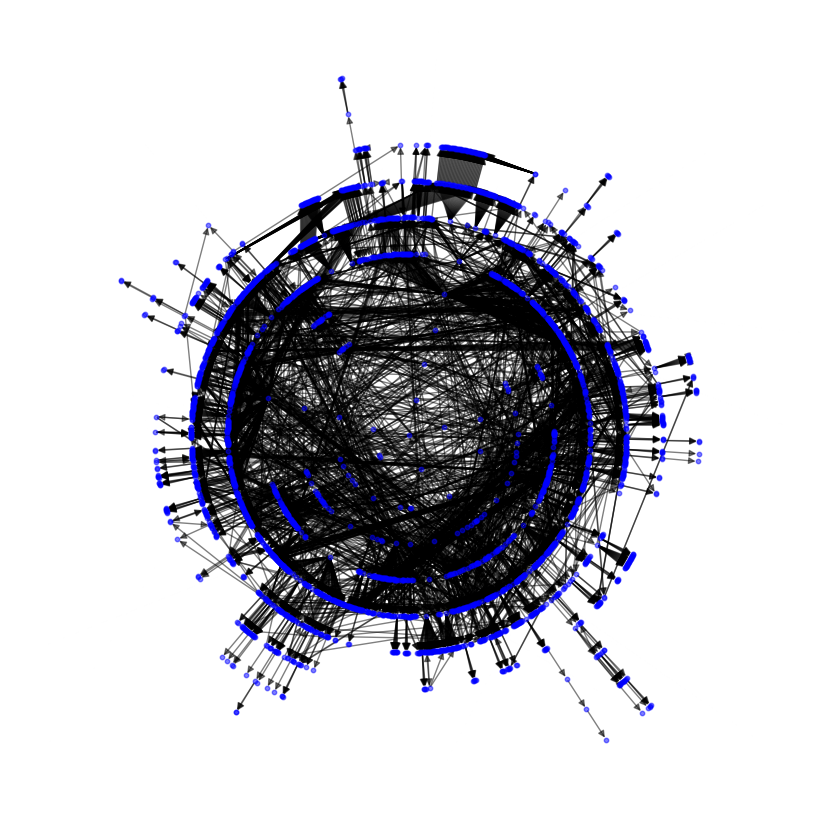

In [15]:
import matplotlib.pyplot as plt

pos = nx.nx_agraph.graphviz_layout(a_graph_cleaned, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(a_graph_cleaned, pos, node_size=10, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()

### Convert to tree topology

In [16]:
# from ChatGPT
from collections import deque

def graph_to_tree_bfs(graph, root_node):
    tree = nx.Graph()
    visited = set()
    queue = deque([root_node])

    while queue:
        current_node = queue.popleft()
        visited.add(current_node)
        tree.add_node(current_node, **graph.nodes[current_node])

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                tree.add_edge(current_node, neighbor)
                queue.append(neighbor)
                visited.add(neighbor)

    return tree


def graph_to_directed_tree_bfs(graph, root_node):
    tree = nx.DiGraph()
    visited = set()
    queue = deque([root_node])

    while queue:
        current_node = queue.popleft()
        visited.add(current_node)
        tree.add_node(current_node, **graph.nodes[current_node])

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                tree.add_edge(current_node, neighbor)
                queue.append(neighbor)
                visited.add(neighbor)

    return tree

In [17]:
# Convert undirected graph to directed tree
a_tree = graph_to_tree_bfs(a_graph_cleaned, root_id)
a_tree_dir = graph_to_directed_tree_bfs(a_graph_cleaned, root_id)


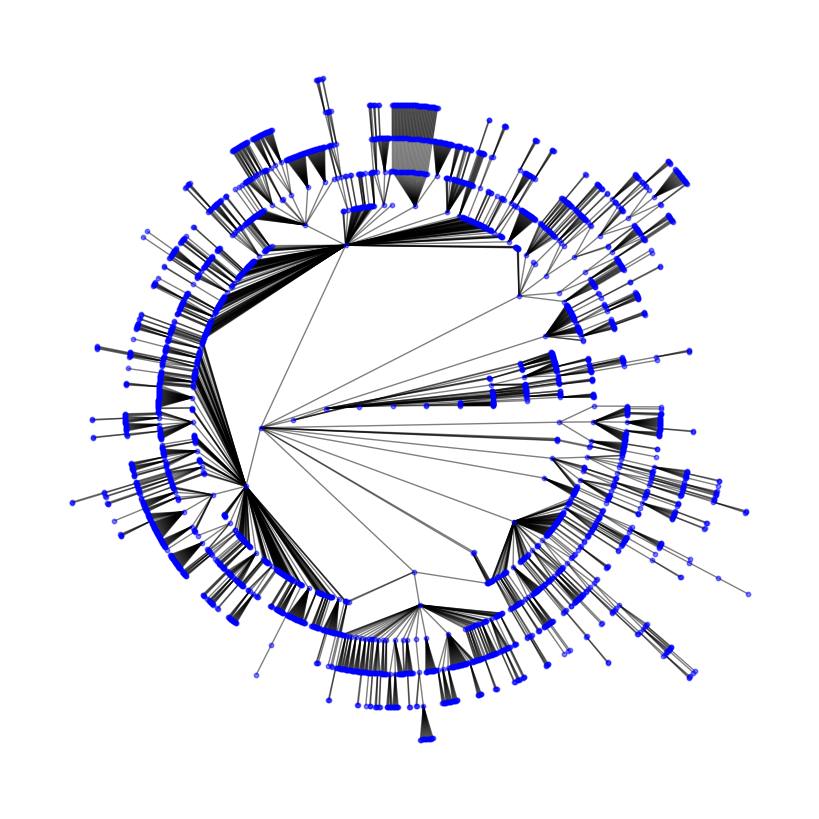

In [18]:
import matplotlib.pyplot as plt

pos = nx.nx_agraph.graphviz_layout(a_tree, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(a_tree, pos, node_size=10, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()

## Calculate aggregate observations that include the node AND its children

In [19]:
node_index = np.asarray(list(a_tree_dir.nodes))
node_index = node_index[np.asarray(node_index) != root_id]

# generate count dict
node_count_dict = dict({})
for node in node_index:
    z_counts = node_df.loc[node_df["node_id"]==node, "zfin_counts"].values[0]
    node_count_dict[node] = z_counts
    
# get DF that contains only the nodes we kept
node_df_tree = node_df.copy()
keep_indices = np.asarray([i for i in node_df_tree["node_id"] if i in node_index])
node_df_tree = node_df_tree.loc[keep_indices, :]
node_df_tree.reset_index(inplace=True, drop=True)

# get counts that include children
for node in node_index:
    
    # initialize
    z_counts = 0
    
    # get counts from successor nodes
    d_nodes = list(nx.descendants(a_tree_dir, node))
    nz_counts = 0
    for d in d_nodes:
        z_counts += node_count_dict[d]
        if node_count_dict[d] > 0:
            nz_counts += 1
        
    node_df_tree.loc[node_df_tree["node_id"]==node, "d_counts"] = z_counts
    node_df_tree.loc[node_df_tree["node_id"]==node, "n_counts"] = len(d_nodes)
    node_df_tree.loc[node_df_tree["node_id"]==node, "nz_counts"] = nz_counts
    
    
x_limit = np.percentile(node_df_tree["zfin_counts"], 95)
y_limit = np.percentile(node_df_tree["d_counts"], 95)

node_df_tree.loc[:, "importance_flag"] = 0
i_filter = (node_df_tree["zfin_counts"] >= x_limit) & (node_df_tree["d_counts"] >= y_limit)
node_df_tree.loc[i_filter, "importance_flag"] = 1
node_df_tree.loc[:, "importance_flag"] = node_df_tree.loc[:, "importance_flag"].astype(str)

node_df_tree["size_counts"] = 25 + node_df_tree.loc[:, "n_counts"].to_numpy() 
node_df_tree.loc[node_df_tree["size_counts"] > 500, "size_counts"] = 500

In [20]:
fig = px.scatter(node_df_tree, x="zfin_counts", y="d_counts", color="importance_flag", size="size_counts",
                 log_x=True, log_y=True,
                 labels={"zfin_counts": "direct zfin observations", 
                         "d_counts": "descendant zfin observations",
                         "importance_flag": "importance flag",
                         "n_counts": "number of descendant phenotypes"},
                hover_data={"Anatomy Name":True, "Anatomy ID":True, "size_counts":False, 
                            "n_counts":True, "importance_flag": False})

fig.update_layout(showlegend=False,
    yaxis_title="# descendant reports", xaxis_title="# direct reports on zfin"
)

fig.show()
fig.write_html(os.path.join(fig_path, "zfin_importance_scatter.html"))

### Now, iterate through genes and calculate the following:

1) Total importance across all phenotypes
2) TF flag
3) Top 3 reported phenotypes by importance
4) Effects for those 3

Iterate through each gene and calculate an aggregate importance score, as well as its top 3 "most important" phenotypes

In [52]:
from tqdm import tqdm 

zfin_pheno_node = zfin_pheno_agg1.merge(node_df.loc[:, ["Anatomy ID", "node_id"]].drop_duplicates(), how="left",
                                      left_on="structure_ID", right_on="Anatomy ID").drop(labels="Anatomy ID", axis=1)

zfin_pheno_node = zfin_pheno_node.loc[:, ["gene", "structure", "structure_ID", "phen_type", "report_counts",
                                          "start_hpf", "node_id"]].drop_duplicates().reset_index(drop=True)

# remove entries with unknown staging info
# print(zfin_pheno_node.shape)
# zfin_pheno_node = zfin_pheno_node.loc[zfin_pheno_node["start_hpf"]>0, :]
# print(zfin_pheno_node.shape)


gene_index = list(gene_pheno_df["gene"])
gene_node_list = []
for g, gene in enumerate(tqdm(gene_index)):
    
    # get nodes for each phenotype
    pheno_nodes = zfin_pheno_node.loc[zfin_pheno_node["gene"]==gene, "node_id"].to_numpy()
    
    # get de-duped list of all descendants
    d_list = list(np.unique(pheno_nodes))
    for d in d_list:
        d_list += list(nx.descendants(a_tree_dir, d))
    
    d_index = np.unique(d_list)
    nz_count = 0
    for d in d_index:
        if node_count_dict[d] > 0:
            nz_count += 1
            
    # add to DF
    gene_pheno_df.loc[g, "importance_score"] = nz_count
    gene_pheno_df.loc[g, "n_zfin_reports"] = np.sum(zfin_pheno_node.loc[zfin_pheno_node["gene"]==gene, "report_counts"])
    
    # get importance ranking for each phenotype
    nz_count_list = []
    dd_nodes = np.unique(pheno_nodes)
    for node in dd_nodes:
        nz = node_df_tree.loc[node_df_tree["node_id"]==node, "nz_counts"].values[0] + 1
        nz_count_list.append(nz)
        
    si = np.argsort(nz_count_list)
    
    # add info to table
    gene_table = zfin_pheno_node.loc[zfin_pheno_node["gene"]==gene, :].reset_index(drop=True)
    ranked_node_ids = dd_nodes[si[::-1]]
    if len(ranked_node_ids) > 0:
        filter0 = gene_table["node_id"]==ranked_node_ids[0]
        gene_pheno_df.loc[g, "phenotype_1"] = gene_table.loc[filter0, "structure"].values[0]
        gene_pheno_df.loc[g, "effect_1"] = gene_table.loc[filter0, "phen_type"].values[0]
        gene_pheno_df.loc[g, "start_hpf_1"] = gene_table.loc[filter0, "start_hpf"].values[0]
    else:
        gene_pheno_df.loc[g, "phenotype_1"] = ""
        gene_pheno_df.loc[g, "effect_1"] = ""
        gene_pheno_df.loc[g, "start_hpf_1"] = np.nan
    
    if len(ranked_node_ids) > 1:
        filter1 = gene_table["node_id"]==ranked_node_ids[1]
        gene_pheno_df.loc[g, "phenotype_2"] = gene_table.loc[filter1, "structure"].values[0]
        gene_pheno_df.loc[g, "effect_2"] = gene_table.loc[filter1, "phen_type"].values[0]
        gene_pheno_df.loc[g, "start_hpf_2"] = gene_table.loc[filter1, "start_hpf"].values[0]
    else:
        gene_pheno_df.loc[g, "phenotype_2"] = ""
        gene_pheno_df.loc[g, "effect_2"] = ""
        gene_pheno_df.loc[g, "start_hpf_2"] = np.nan
        
    if len(ranked_node_ids) > 2:
        filter2 = gene_table["node_id"]==ranked_node_ids[2]
        gene_pheno_df.loc[g, "phenotype_3"] = gene_table.loc[filter2, "structure"].values[0]
        gene_pheno_df.loc[g, "effect_3"] = gene_table.loc[filter2, "phen_type"].values[0]
        gene_pheno_df.loc[g, "start_hpf_3"] = gene_table.loc[filter2, "start_hpf"].values[0]
    else:
        gene_pheno_df.loc[g, "phenotype_3"] = ""
        gene_pheno_df.loc[g, "effect_3"] = ""
        gene_pheno_df.loc[g, "start_hpf_3"] = np.nan
        
        
# remove genes with no phenotype
print(gene_pheno_df.shape)
gene_pheno_df = gene_pheno_df.loc[gene_pheno_df["phenotype_1"] != "", :]
print(gene_pheno_df.shape)

100%|██████████| 3528/3528 [00:11<00:00, 296.01it/s]

(3528, 16)
(3528, 16)


In [53]:
gene_pheno_df = gene_pheno_df.sort_values(by=["TF_flag", "importance_score"], axis=0, ascending=False)
gene_pheno_df.reset_index(inplace=True, drop=True)
gene_pheno_df.to_csv(os.path.join(built_data_dir, "zfin_gene_KO_candidates.csv"))

In [54]:
gene_pheno_df.head()

gene              gene_ID  chromatin_flag  \
0  fosl2  ZDB-GENE-070209-164             0.0   
1   vrtn  ZDB-GENE-060929-700             1.0   
2  tbx16    ZDB-GENE-990615-5             1.0   
3  hdac1   ZDB-GENE-020419-32             0.0   
4   cdx4  ZDB-GENE-980526-330             1.0   

                                           gene_desc  TF_flag  \
0  Predicted to enable DNA-binding transcription ...      1.0   
1  Enables DNA-binding transcription repressor ac...      1.0   
2  Enables transcription cis-regulatory region bi...      1.0   
3  Enables transcription corepressor activity. In...      1.0   
4  Enables DNA binding activity and chromatin bin...      1.0   

   importance_score  n_zfin_reports           phenotype_1  \
0             973.0            10.0  anatomical structure   
1             973.0             8.0  anatomical structure   
2             259.0           103.0                  cell   
3             163.0           131.0                somite   
4             151.0            66.0     anatomical system   

                                       effect_1  start_hpf_1  \
0                                        absent        30.00   
1            decreased amount, increased amount         5.25   
2                                  accumulation        24.00   
3  U-shaped, decreased amount, decreased amount        24.00   
4                                       quality         0.00   

         phenotype_2                           effect_2  start_hpf_2  \
0  bulbus arteriosus           absent, increased amount         48.0   
1             somite                   decreased amount         36.0   
2             somite  aplastic, quality, aplastic, size          0.0   
3     nervous system                            quality          0.0   
4             somite                          condensed         16.0   

         phenotype_3                                  effect_3  start_hpf_3  
0              heart  increased distribution, increased amount        48.00  
1               head          decreased length, decreased size        11.66  
2  surface structure                                   quality         0.00  
3               head  decreased size, arrested, decreased size        48.00  
4              trunk        decreased length, decreased length        24.00